In [1]:
import pandas as pd
from pyspark import SparkContext
import time
import numpy as np
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# import seaborn as sns
startTime = time.time()

In [2]:
sc = SparkContext("local[*]", "UserUserRating")

In [3]:
trainData = sc.textFile("/Users/apple/Desktop/DataMining/project/user_business_rating_user_sim.csv")
trainDataFirst = trainData.first()
trainData = trainData.filter(lambda x: x != trainDataFirst)
trainData = trainData.map(lambda l: l.split(','))
trainData = trainData.map(lambda x : (x[1],x[2],x[3])).collect()

In [4]:
trainData = trainData[:40000]

In [4]:
users = {}
businesses = {}
finalInput = []
ratings = []

In [5]:
for i in trainData:
    if users.get(i[0]) is None:
        users[i[0]] = len(users) + 1
    if businesses.get(i[1]) is None:
        businesses[i[1]] = len(businesses) + 1
    ratings.append(float(i[2].strip()))
    finalInput.append([users[i[0]],businesses[i[1]],float(i[2].strip())])

In [6]:
invUsers = {str(v): k for k, v in users.items()}
invBusinesses = {str(v): k for k, v in businesses.items()}

trainAvgRating = [float(sum(col))/len(col) for col in zip(*finalInput)][2]
minVal = min(ratings)
maxVal = max(ratings)


In [7]:
finalTrainInput = sc.parallelize(finalInput)

userAverage = finalTrainInput.map(lambda l: (l[0], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
userAverage = userAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

businesAverage = finalTrainInput.map(lambda l: (l[1], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
businesAverage = businesAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

In [8]:
trainRdd = finalTrainInput
trainRddUsers = trainRdd.map(lambda x : ((str(x[0]), str(x[1])), (float(x[2])-minVal)/(maxVal-minVal)))
trainingRddUsers = trainRddUsers.map(lambda x : (x[0][0], (x[0][1], x[1])))
businessesOnlyUserCF = trainingRddUsers.map(lambda x : (x[1][0], x[0]))
businessesOnlyUserCF = businessesOnlyUserCF.groupByKey()
businessesOnlyUserCF = businessesOnlyUserCF.mapValues(list)
businessesOnlyUserCF = businessesOnlyUserCF.collectAsMap()
userAndBusinessesUserCF = trainingRddUsers.map(lambda x : ((x[0], x[1][0]), x[1][1]))
userAndBusinessesUserCF = userAndBusinessesUserCF.collectAsMap()

usersOnlyUserCF = trainingRddUsers.groupByKey()
usersOnlyUserCF = usersOnlyUserCF.mapValues(list)
usersOnlyUserCF = usersOnlyUserCF.collectAsMap()

In [9]:
def calcPearsonUsers(corratedUsersBusinessess):
    if len(corratedUsersBusinessess) == 0:
        return -100
    if len(corratedUsersBusinessess) == 1:
        return -100
    tempUB = [x[1][0] for x in corratedUsersBusinessess]
    tempUBAvg = sum(tempUB)/len(tempUB)
    pearsonNumerator = 0
    pearsonDenom1 = 0
    pearsonDenom2 = 0
    allUB = [x[1][1] for x in corratedUsersBusinessess]
    for (i, j) in zip(tempUB, allUB):
        pearsonNumerator += (i-tempUBAvg)*(j-tempUBAvg)
        pearsonDenom1 += (i-tempUBAvg)**2
        pearsonDenom2 += (j-tempUBAvg)**2
    pearsonDenom = (pearsonDenom1**0.5) * (pearsonDenom2**0.5)
    if pearsonDenom == 0 or pearsonNumerator == 0:
        return -100
    else:
        return pearsonNumerator/pearsonDenom

In [10]:
user_ids = usersOnlyUserCF.keys()

In [13]:
user_vs_business ={}
import pandas as pd
for k , v in usersOnlyUserCF.items():
    user_vs_business [k] =  len(v)
data = {"user" : user_vs_business.keys() , "count_business" : user_vs_business.values()}
df =  pd.DataFrame.from_dict(data)
df_new = df[ (df.count_business <50 ) & ( df.count_business >40 )]


In [14]:
user_ids =df_new.user.unique()

In [15]:
len(user_ids)

854

In [16]:
pearson_between_users= []

In [17]:
for i,user1 in enumerate(user_ids[:-1]):
    for j , user2 in enumerate(user_ids[i+1:]):
        eachUserInfo = usersOnlyUserCF[user1]
        tempKnnUsersInfo = usersOnlyUserCF[user2]
        corratedUsersBusinessess = []
        tempKnnUsersInfo.sort()
        eachUserInfo.sort()
        l= 0
        k = 0
        while l<len(tempKnnUsersInfo) and k< len(eachUserInfo):
            if tempKnnUsersInfo[l][0] == eachUserInfo[k][0]:
                corratedUsersBusinessess.append((tempKnnUsersInfo[l][0], (tempKnnUsersInfo[l][1], eachUserInfo[k][1])))
                l = l+1
                k = k+1
            elif tempKnnUsersInfo[l][0] < eachUserInfo[k][0]:
                l = l+1
            else:
                k = k+1
       
        pearsonRating = calcPearsonUsers(corratedUsersBusinessess)
        if pearsonRating != -100:
            pearson_between_users.append((user1,user2,pearsonRating))

In [18]:
pearson_between_users

[('46131', '17253', 0.37139067635410367),
 ('46131', '16995', -0.2886751345948129),
 ('46131', '14115', 0.1796053020267749),
 ('46131', '24655', -0.6708203932499368),
 ('46131', '48096', 0.3746343246326776),
 ('46131', '5275', 0.24253562503633297),
 ('46131', '14194', 0.6333004963811235),
 ('46131', '39998', -0.31622776601683794),
 ('46131', '48589', 0.12009611535381544),
 ('46131', '14807', -0.26173212203263035),
 ('46131', '1286', -0.077615052570633),
 ('46131', '27257', -0.24253562503633297),
 ('46131', '42092', 0.7999999999999998),
 ('46131', '15065', -0.9701425001453319),
 ('46131', '45083', 1.3457935360146642e-16),
 ('46131', '34452', -0.16439898730535726),
 ('46131', '29451', -0.11470786693528126),
 ('46131', '6610', -0.11470786693528087),
 ('46131', '41944', -0.492365963917331),
 ('46131', '19725', -0.05581455721859476),
 ('46131', '44263', -0.26506756544202803),
 ('46131', '46948', 0.8320502943378437),
 ('46131', '30527', -0.242535625036333),
 ('46131', '26226', 0.316227766016

In [19]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession(sc)

In [20]:
pearson_rdd = sc.parallelize(pearson_between_users)

In [21]:

pearson_rdd = sc.parallelize(pearson_between_users)  


# convert to code and Use below to dump user-user pearson to file

In [22]:
pearson_rdd

ParallelCollectionRDD[27] at parallelize at PythonRDD.scala:184

In [24]:
def p(x):
    print(x)
    
pearson_rdd.foreach(p)

In [25]:
import pandas as pd
import numpy as np
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
pearson_rdd=pearson_rdd.toDF()

In [27]:
pearson_df=pearson_rdd.toPandas()

In [28]:
pearson_df.head(10)

,_1,_2,_3
0,46131,17253,0.371391
1,46131,16995,-0.288675
2,46131,14115,0.179605
3,46131,24655,-0.670820
4,46131,48096,0.374634
5,46131,5275,0.242536
6,46131,14194,0.633300
7,46131,39998,-0.316228
8,46131,48589,0.120096
9,46131,14807,-0.261732


In [29]:
pearson_df.count()

_1    15498
_2    15498
_3    15498
dtype: int64

In [32]:
pearson_df["_3"].describe()

count    15498.000000
mean         0.089751
std          0.655449
min         -1.000000
25%         -0.452267
50%          0.188982
75%          0.707107
max          1.000000
Name: _3, dtype: float64

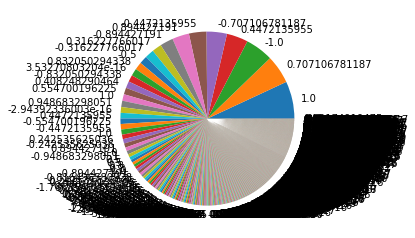

In [33]:
pearson_df["_3"].value_counts().plot.pie()
plt.gca().set_aspect("equal")


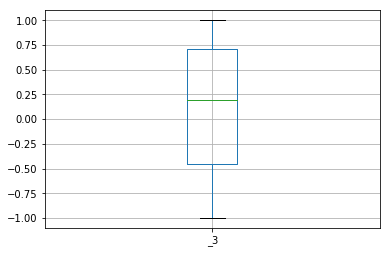

In [34]:
boxplot = pearson_df.boxplot(column=["_3"])

In [49]:
data = pearson_df[pearson_df._3 > 0.97]

In [50]:
data.count()

_1    1558
_2    1558
_3    1558
dtype: int64

In [51]:
G = nx.from_pandas_edgelist(data, "_1", "_2", ["_3"])

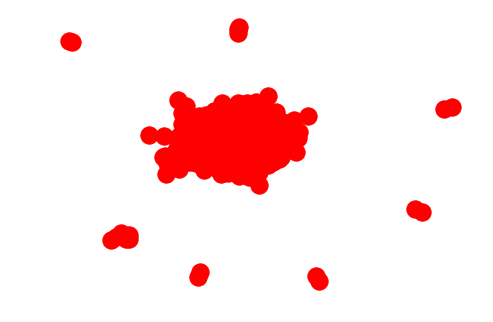

In [52]:
nx.draw(G)
plt.show()

In [53]:
nx.classes.function.density(G)

0.0053735070238427815

In [47]:
comp = nx.algorithms.community.centrality.girvan_newman(G)

In [48]:
cnt=0
d={}
for c in next(comp):
    #print(c)
    d[cnt]=len(c)
    #print(len(c))
    #print("\n")
    cnt+=1
print("number of communities"+str(cnt))    
print(d)
    

number of communities8
{0: 771, 1: 2, 2: 2, 3: 2, 4: 2, 5: 4, 6: 3, 7: 2}
